In general, using photographic images to answer biological questions requires at least three steps: 

1) [Making maps](#digitize): process the image a schematic of the image that recognizes and retains the parts of the photo that are informational.

2) [Measuring raw data from from this map](#zones): calling zones, counting spots, etc.

3) Run statistical analyses on these data

All three of these steps require a lot of decision making and coding. What follows is a review of the path I've taken to get to statistical analysis for our images. If the code is confusing to read, skip it. 

[Python Setup](#pythonSetup)

<h1><a id="digitize">Making maps out of flower photos</a></h1>

<a id='dougOut'><h3>Getting images out of Doug's raster pipeline</h3></a>

Flower photos were broken into their various petals of interest, and color differences were categorized, by forcing all pixels into three color poles using kmeans clustering. Doug coded this pipeline, and Melia implemented it, also doing manual corrections where needed. A "bottom" petal, for instance looks like this, after Doug's pipeline (converted to grayscale):

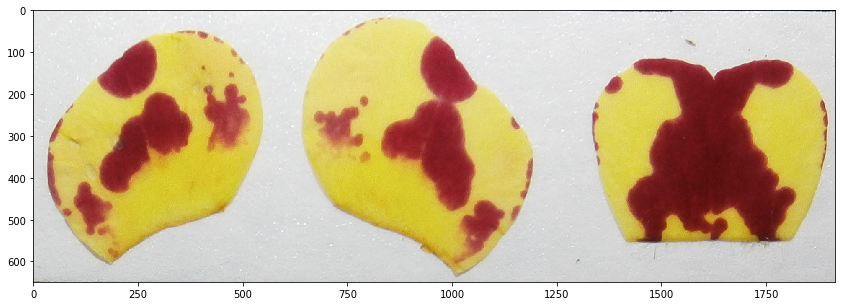

In [18]:
## stay in python for a sec, before we go to matlab/octave
exFlowerImage="/home/daniel/Documents/cooley_lab/mimulusSpeckling/dougRaster/Rotated_and_Cropped/P431F1.JPG"

plt.rcParams['figure.figsize'] = [15, 5]

img=mpimg.imread(exFlowerImage)
plt.imshow(img)

In matlab, we can see how Doug's pipeline sees these petals:

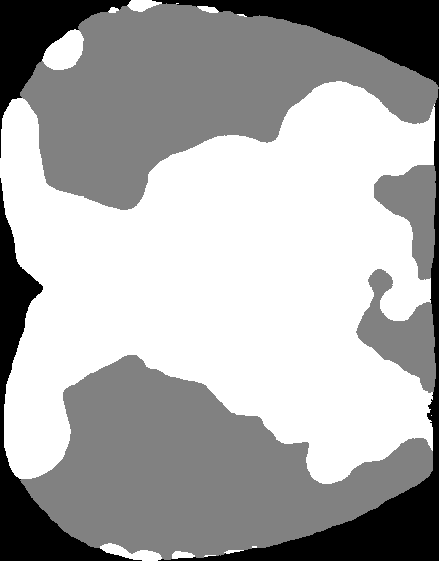

In [1]:
load("../dougRaster/Rotated_and_Cropped/P431F1.mat")
pkg load image
aa = mat2gray(Petals.Clusters.right);
imshow(aa) %% that works.

We want to make polygons of spots and their petals. We can begin by "peeling" these two apart into separate, solid-black images:

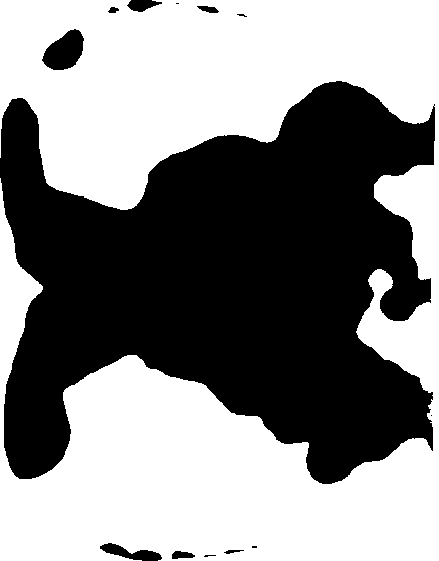

In [2]:
bb = aa < 1;
imshow(bb);


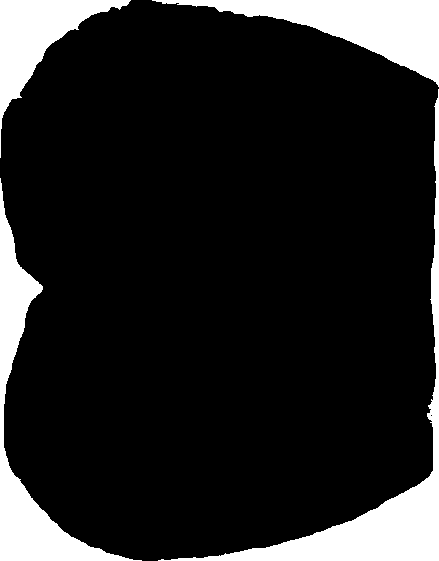

In [3]:
cc = aa == 0;
imshow(cc);

We can generalize the above process, to get all of the available photos from Doug's efforts into a form ready to digitized. I wrote a matlab script for this:

In [1]:
cat prepDougRasters.m

wd = '/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/polygons';
dougRasterDir = '/home/daniel/Documents/cooley_lab/mimulusSpeckling/dougRaster/Rotated_and_Cropped';
cd(dougRasterDir)

files = dir('P*.mat');

for file = files';
    im = file.name;
    imName = regexprep(im,'\.mat', ''); 
    %% go get our file, come back
    cd(dougRasterDir);
    rast=load(im);
    cd(wd);
    %% make a spot for our image, go to it:
    mkdir(imName);
    cd (imName);
    %% get our petal names (left, right mid)
    petNames = fieldnames(rast.Petals.Clusters);
    %% split images into petal and spot, export, for each of the three petals:
    for i = 1:length(petNames);
        pet = rast.Petals.(petNames{i}).data; %petal at hand
        mkdir(petNames{i});
        cd(petNames{i});
        %% for octave
        fileNamePetal = [imName "_" char(petNames(i)) "_" 'melted.csv'];
        %% for matlab, this may work better?
        %%fileNamePetal = imName + "_" +  petNames(i) + "_" + 'melt

This is brittle code, if the file architectures or Doug's matlab structures changes, it will break. But most of it should be useful/re-useable, so including it here. 

<a id='skimmage'><h3>Digitizing petal outlines and spots with scikit-image</h3></a>

Let's go to python, in particular [scikit-image](https://scikit-image.org/), and [shapely](toblerity.org/shapely/manual.html). These are among the standard packages for manipulating images and polygons in python. 

<a id="pythonSetup"></a>

In [19]:
import argparse, os, pickle
import geojsonIO
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as sg
import shapely.affinity as sa
import matplotlib.image as mpimg
from skimage import measure
from descartes import PolygonPatch

An informal package of modules for digitizing these flower petals and their spots is emerging from this project. The github repo for this is currently <a href="https://github.com/danchurch/mimulusSpeckling/tree/master/make_polygons"> here </a>. What follows is a look at some of the functions inside these modules:

<h5><a id='parseDoug'>Parse CSVs from Doug's Matlab pipeline into a python data object</a></h5>

Above we dug into Doug's matlab pipeline, and extract the data we needed from his matlab data objects into a more universal format, a CSV. Now here is a function to read these and convert them into a 2D numpy array that is the same size as the images themselves, 

In [3]:
def parseDougMatrix(file):
    """Get numpy arrays that can be used as images
    from Doug's melted matrix that results
    when you manually correct his color centers """
    orig = np.genfromtxt(file, delimiter=',')
    orig = orig.astype(int)
    Ymax=np.max(orig[:,1])
    Xmax=np.max(orig[:,0])
    petal = np.zeros([Xmax,Ymax])
    spots = np.zeros([Xmax,Ymax])
    for i in orig:
        petal[i[0]-1,i[1]-1] = i[3]
        spots[i[0]-1,i[1]-1] = i[3]
    ## 0 is background color
    ## 2 is petal color
    ## 3 is spot color
    petal = petal.astype(int)
    petal[petal == 0] = 1
    petal[petal == 2] = 0
    petal[petal == 3] = 0
    spots = spots.astype(int)
    spots[spots == 0] = 1
    spots[spots == 2] = 1
    spots[spots == 3] = 0
    return(petal,spots)

<h5><a id='getPolys'>Get petal and spot polygons</a></h5>

We'll get the petal and spots from these images, by tracing their outlines. It uses the <a href="http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours">find_contours</a> function from skimage. These outlines are then used to make shapely polygon objects, and are then wrapped into a single multipolygon object. 

In [4]:
def digitizePols(mat):
    """pad margins of image and get the contour of the petal shape"""
    ## is the matrix just background color? then return empty polygon
    if (mat == 1).all():
            shapelyPoly = sg.Polygon()
    else:
        petal_marg = np.insert(mat, mat.shape[1], 1, 1)
        petal_marg = np.insert(petal_marg, 0, 1, 1)
        petal_marg = np.insert(petal_marg, mat.shape[0], 1, 0)
        petal_marg = np.insert(petal_marg, 0, 1, 0)
        Pcontours = measure.find_contours(petal_marg, 0)
        if Pcontours:
            #return(Pcontours)
            ## gotta ditch <3 points, they are lines
            polys = [ i for i in Pcontours if len(i) >= 4 ]
            ## make shapely objects
            if len(polys) == 1:
                shapelyPoly = sg.Polygon(polys[0])
            elif len(polys) > 1:
                lpols = [ sg.Polygon(i) for i in polys ]
                shapelyPoly = sg.MultiPolygon(lpols)
        elif not Pcontours: shapelyPoly = sg.MultiPolygon()
    return(shapelyPoly)


<h5><a id="StPets">Standardizing petals</a></h5>

To make flowers of different ages, sizes - and those captured from different photo setups - comparable, we will standardize them a bit. We need to look at our raw petal outlines first, to create a reference for centering and scaling (standardizing) the petal and spots. This function gets the information (centroid, scaling constant) we need to do that:

With this info, we can craft a function to "standardize" our petals and our spots. In our case, that means center the petal and the array of spots to the origin, to scale the petal polygon to area =1, and scale the spots by this same ratio:

In [5]:
def getPetGeoInfo(pet):
    """get centroid and scaling factor needed to standardize petals and spots"""
    area = pet.area
    scalar = area**(-1/2)
    center = pet.centroid
    centerCoor = (center.x, center.y)
    return(scalar, centerCoor)

We do the actual matrix transformations here:

In [8]:
def stand(pol, scale, cent):
    """standardize a polygon"""
    trans = sa.translate(pol, (-1*cent[0]), (-1*cent[1]))
    scaled = sa.scale(trans, xfact=scale, yfact=scale, origin = (0,0))
    return(scaled)

These functions, plus some helper cleanup functions, are the module "[get_spots.py](https://raw.githubusercontent.com/danchurch/mimulusSpeckling/master/make_polygons/get_spots.py)". Ultimately, spots and petal outlines are exported as part of a geometry collection of a [geojson](http://geojson.org/) file. More on this below. These geojsons are passed onto the next step, where zones of the petals are called, described next. 

Looking at same petal as we started with:

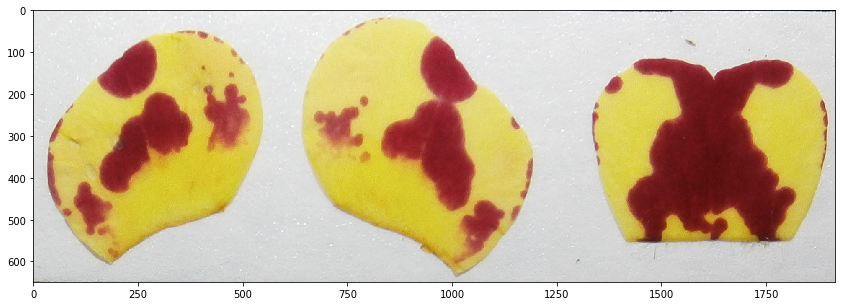

In [17]:
exFlowerImage="/home/daniel/Documents/cooley_lab/mimulusSpeckling/dougRaster/Rotated_and_Cropped/P431F1.JPG"
plt.rcParams['figure.figsize'] = [15, 5]
img=mpimg.imread(exFlowerImage)
plt.imshow(img)

After applying the above digitizing functions, we get petals with an area of 1, centered at 0,0 : 

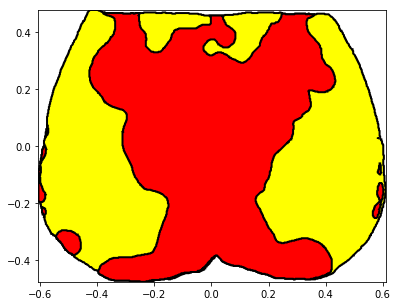

In [29]:
exPol=geojsonIO.parseGeoJson("/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/geojsons_working/P431F1_right_polys.geojson")

geojsonIO.plotOne(exPol[0]); geojsonIO.addOne(exPol[1])

<h1><a id="zones">Measuring raw data</a></h1>

<h3><a id="callZones">Calling center, edge and throat zones</a></h3>

We'll define three zones of interest - center, margin and petal. In another module, "[get_zones.py](https://raw.githubusercontent.com/danchurch/mimulusSpeckling/master/make_polygons/get_zones.py)", we define the proportion ('percent') of petal we would like to remain as "center", and the rest is given to the margin and throat. 

This is done using two functions. To call an internal "Center" zone that is 50% (the default setting) of the petal area, we iteratively grow a margin inside the petal polygon until the remaining center approximates 50%:

In [31]:
def findCenter(standPol, percent):
    ## generate margin/center
    center = standPol
    rad = 0
    while center.area > percent:
        center = standPol.buffer(rad)
        rad -= .001
    cent = sg.polygon.Polygon(center.exterior.coords)
    return(cent)

Finding the throat is trickier. Without developing some smarter computer vision, our best landmarks are the corners on these petals from the cuts with which they were originally separated. We try to find these using the "[simplify](#https://shapely.readthedocs.io/en/stable/manual.html#other-operations)" function from shapely, which reduces the number of vertices in a polygon:

In [ ]:
def findEdgeThroat(petal, center, simp=0.5):
    #simp=0.5
    ## generate margin/center
    petal = cleanPoly(petal)
    center = cleanPoly(center)
    marg = sg.polygon.Polygon(
            petal.exterior,
            holes = [center.exterior.coords])
    ## break up margin into edge and throat:
    simPol = marg.simplify(simp)
    ## get array of x,y coords separated
    simPolA = np.array(simPol.exterior.xy).transpose()
    ## sort by y coords:
    simPolAsorted = simPolA[simPolA[:,1].argsort()[::-1]]
    leftSide=simPolAsorted[simPolAsorted[:,0] < 0]
    upperleft=leftSide[0,:]
    rightSide=simPolAsorted[simPolAsorted[:,0] > 0]
    upperright=rightSide[0,:]
    simPolB = np.array(simPol.interiors[0].xy).transpose()
    simPolBsorted = simPolB[simPolB[:,1].argsort()[::-1]]
    leftSide=simPolBsorted[simPolBsorted[:,0] < 0]
    lowerleft=leftSide[0,:]
    rightSide=simPolBsorted[simPolBsorted[:,0] > 0]
    lowerright=rightSide[0,:]
    corners = np.stack((upperleft, upperright,lowerright,lowerleft))
    tRapPoly = cleanPoly(sg.polygon.Polygon(corners))
    try:
        tBuff = tRapPoly.buffer(0.1)
        tBuff = cleanPoly(tBuff)
        noTrap = marg.difference(tRapPoly)
        notInTrap = [ i for i in noTrap if i.within(tBuff) ]
        mpNotInTrap = sg.multipolygon.MultiPolygon(notInTrap)
        margInTrap = tRapPoly.intersection(marg)
        throatRaw = margInTrap.union(mpNotInTrap )
        throat = cleanCollections(throatRaw)
        edgeRaw = marg.difference(throat)
        edge = cleanCollections(edgeRaw)
    except:
        print ("Zones failed...")
        edge, throat = None, None
    finally:
        return(edge, throat)


There is a lot going on in that function. Some helper functions try to clean up small junk geometries created by our petal/spot digitizing and our throat/edge separation. These are then given to the center-finding algortithm. Following this, separation of margin into edge and throat are done, dependent on the simplification method of polygons in shapely mentioned above. Using this we harden the lines of the polygon according to the "simp" parameter of the function. This results in fewer vertices and we pick the top two vertices in our petal outline and in our margin to delineate the four corners of the throat. This works as a first guess but fails often for finding the throat/edge. So downstream we have built in a manual correction/sanity check into this pipeline. 

Also on the todo list is the handling of errors, here and elsewhere I have mostly left them blank in my hurry to get some results to play with. If any of this data turns out to be useful, some exception types will have to be defined. 

With these functions, we can take the petal and spots from doug's rasters and make some standardized petal and spot polygons:

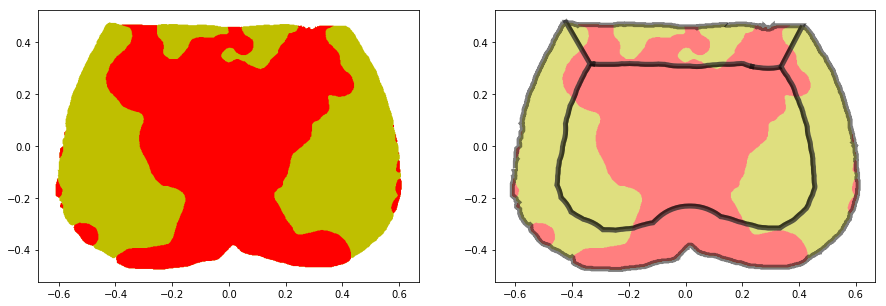

In [16]:
pZones(standPet, spotz, center, edge, throat)

We have a petal area = 1, and petal centroid is on the origin. Zones are coming along. Generally, looks good. But how about our upper petals (doug's "left" and "mid" petals)?

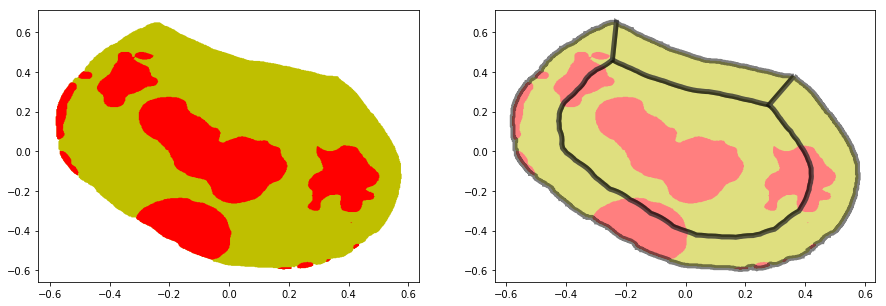

In [20]:
pZones(standPet, spotz, center, edge, throat)

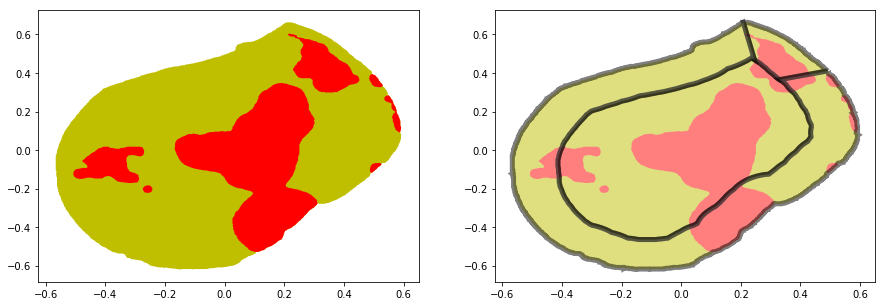

In [28]:
pZones(standPet, spotz, center, edge, throat)

We see that the throat delineation fails. That was with the default simp=0.5 for polygon simplification. Sometimes we can improve things a bit with a harder simplification:

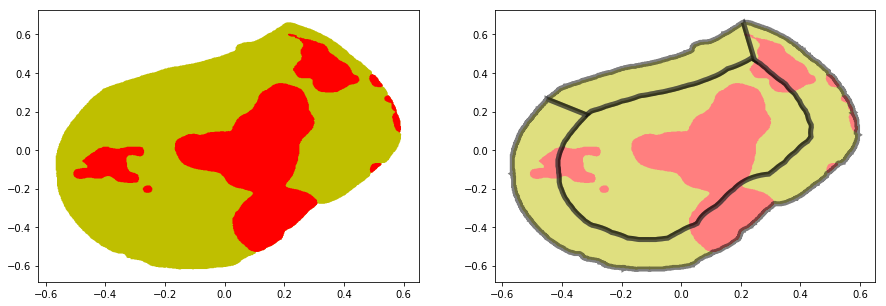

In [31]:
center, edge, throat = findZones(standPet, percent=0.5, simp=0.1)
pZones(standPet, spotz, center, edge, throat)

That worked. So at times it works to play with the simplification parameter. The defult settings sometimes work, sometimes not. But in general the throat zones are again a major problem, manual correction or some badass machine learning are the only way out. We will use manual correction, below. 

<h3><a>Applying our digitizing and Zone-calling to all files</a></h3>

To use these functions across all of our flower petals, we have these functions in a module, with a \_\_main\_\_ script for applying this. It's in the [github repo](https://github.com/danchurch/mimulusSpeckling/blob/master/make_polygons/get_pols.py), and is used on the command line like this:

So we can run this script on one of our black-and-white CSVs that we got from doug's pipeline [(above)](#dougOut). It works on a folder that contains the black-n-white csvs of petals and polygons, named according to Doug's original filename protocol:

`get_pols.py [folder with raster CSVs] [size of center polygon as percentage of petal] [destination folder]` 

A bash script for applying the petal/spot digitizing and zone-calling to all of the jpgs that I have from Melia and Doug:

In [ ]:
#!/usr/bin/env bash

getSpots='/Users/danthomas/Documents/speckling/make_polygons/get_spots.py'
getZones='/Users/danthomas/Documents/speckling/make_polygons/get_zones.py'
wd='/Users/danthomas/Documents/speckling/make_polygons/polygons'

cd $wd

for i in *; do
    echo $i 
    cd $i 
    for j in *; do
        fullN=$PWD/$j
        $getSpots $fullN $fullN
        find $fullN -name "*.geojson" -exec $getZones {} 0.5 \;
    done
    cd ../
done


<h3><a>Geojson files equal freedom</a></h3>

The result of this pipeline are [geojson](http://geojson.org/) files. They should be viewable and editable in many types of software. If we need it and have time, this will be a convenient way to quality check and correct the spot polygons. With some GIS software like ARCGIS or QGIS, We can break up the petal spots that merged, etc. 

In [36]:
plt.rcParams['figure.figsize'] = [20, 20]

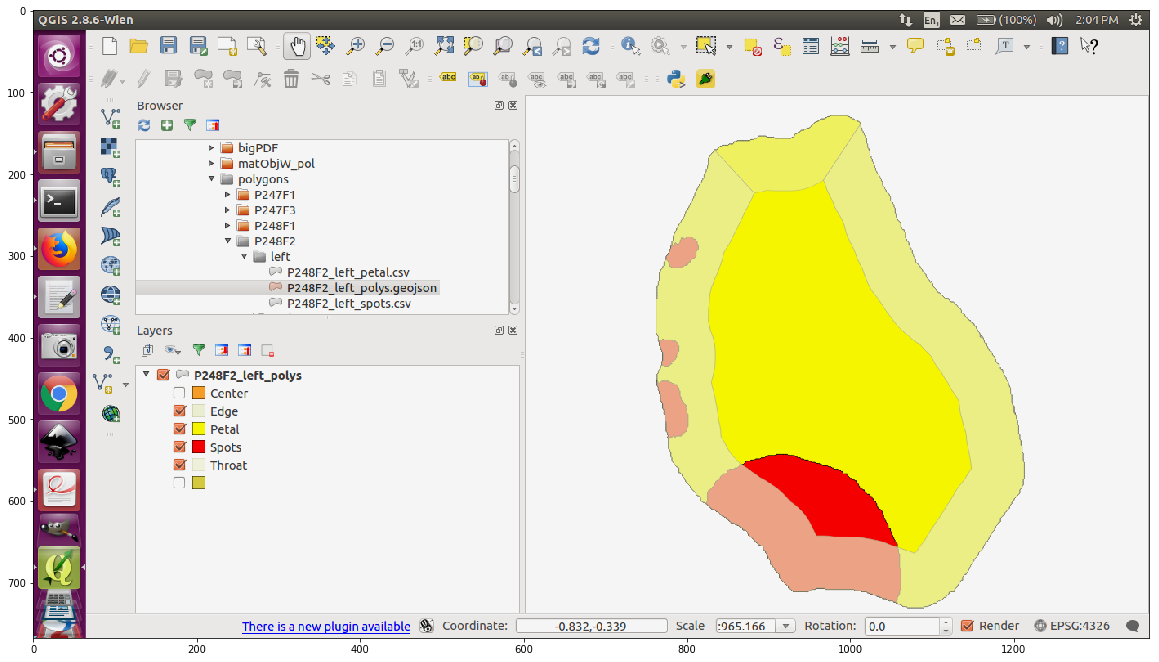

In [37]:
img=mpimg.imread('qGISscreenshot.png')
plt.imshow(img)